### **Класифікація зображень надзвичайних ситуацій за допомогою EfficientNet та TensorFlow/Keras** 

_(Версія для Apple M1/M2)_

Аерофото надзвичайних ситуацій були зібрані з різних онлайн-джерел (наприклад, зображень Google, зображень Bing, YouTube, веб-сайтів новинних агентств тощо) з використанням ключових слів «Вид з повітря», «БПЛА» або «Дрон» та таких подій, як пожежа або задимлення, повінь, обвалення або руйнування будівлі та дорожньо-транспортна пригода. При цьому використовуються також зображення без негативних подій - звичайна ситуація.

**Ключові особливості скрипта**

_Завантаження та розпакування_: використовує requests для завантаження AIDER.zip з наданого посилання та zipfile для розпакування в локальну директорію.

_Підготовка даних_: завантажує зображення з папок (traffic_incident, collapsed_building, fire, flooded_areas, normal), призначає мітки, нормалізує розмір (наприклад, 224x224 для CNN) та розділяє на тренувальний/тестовий набори. Обробляє незбалансованість (наприклад, 4390 зображень у "normal").

_Класифікація_: використовує CNN на базі Keras/TensorFlow для класифікації зображень за 5 класами.

_Вимоги_: за потреби встановіть залежності `pip install requests tensorflow keras opencv-python ultralytics segmentation-models matplotlib scikit-learn`

### **Налаштування**

In [1]:
import os # Доступ до операцій файлової системи: створення, переміщення, видалення файлів і папок
from os import listdir
from pathlib import Path
from os.path import isfile, join
import re # Регулярні вирази — для пошуку, заміни або перевірки шаблонів у тексті
import time # Вимірювання часу, затримки, таймери — корисно для логування або контролю продуктивності
import shutil # Копіювання та переміщення файлів і директорій
import zipfile # Робота з ZIP-архівами: розпаковування, створення, перегляд вмісту
import requests 
import urllib.request # Завантаження файлів з інтернету (наприклад, моделей або датасетів)
import numpy as np
import matplotlib.pyplot as plt # Побудова графіків, гістограм, зображень — корисно для аналізу результатів моделі
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

#pip install opencv-python tensorflow keras
import cv2 # Бібліотека OpenCV — інструмент для комп’ютерного зору: обробка зображень, відео, фільтрація, розпізнавання об'єктів
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Генерація зображень з аугментацією (зміна масштабу, обертання, дзеркалення) — покращує навчання моделі
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#!python -V
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Приховати попередження
# Перевірка версій
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.11.2


### **Данні**

In [3]:
# Завантаження та розпакування AIDER.zip

root = Path("./Data") # Це – для роботи з файлами та папками.
root.mkdir(parents=True, exist_ok=True)  # "створити папку" (make directory).
                                         # parents=True – якщо потрібно, вказати весь шлях
                                         # exist_ok=True не кидатиме помилку, якщо така тека вже є.

file = 'AIDER.zip'
url = 'https://zenodo.org/records/3888300/files/' + file  # офіційне джерело

extracted_path = 'AIDER'
zip_path = root / file # Місце, куди збережемо файл архіву.
data_dir = root / extracted_path  # Папка, куди потім розпаковуватимемо

print(f"📁 Робоча директорія: {root}")
print(f"📦 Шлях до архіву: {zip_path}")
print(f"📂 Шлях до даних: {data_dir}")

📁 Робоча директорія: Data
📦 Шлях до архіву: Data/AIDER.zip
📂 Шлях до даних: Data/AIDER


In [4]:
# Перевірка, чи файл AIDER.zip або папка AIDER уже є в вказаній папці
# Якщо ні, відбудеться завантаження zip-файла
if not zip_path.exists() and not data_dir.exists():
    print("Downloading AIDER.zip ...")  
    with requests.get(url,      # HTTP-запит на завантаження
                      stream=True) as r:  # stream=True – “завантажуй потоково”, тобто по частинах, не завантажуючи весь файл у пам’ять
        r.raise_for_status()    # Підніме помилку, якщо сервер повернув код 4xx/5xx
        with open(zip_path, "wb") as f:   # Відкриває файл для запису в двійковому режимі ("wb").
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                # Читає відповідь невеликими порціями по ~8 КБ і одразу записує на диск
else:
    print("AIDER.zip already exists.")

if not data_dir.exists():
    print("Extracting AIDER.zip ...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(root)
    # Якщо архів витягнувся в поточну папку без вкладеної "AIDER", нормалізуємо шлях:
    # чекаємо структуру з 5 папками: traffic_incident, collapsed_building, fire, flooded_areas, normal
    # Якщо файли опинилися в root, перенесемо в data_dir
    expected_classes = {"traffic_incident","collapsed_building","fire","flooded_areas","normal"}
    present = {p.name for p in root.iterdir() if p.is_dir()}
    if expected_classes.issubset(present):
        data_dir.mkdir(exist_ok=True)
        for cls in expected_classes:
            shutil.move(str(root/cls), str(data_dir/cls))
else:
    print("AIDER already extracted.")

print("Extracted folders:", [p.name for p in data_dir.iterdir() if p.is_dir()])

AIDER.zip already exists.
AIDER already extracted.
Extracted folders: ['collapsed_building', 'fire', 'normal', 'traffic_incident', 'flooded_areas']


### **Огляд даних і перевірка дисбалансу класів**

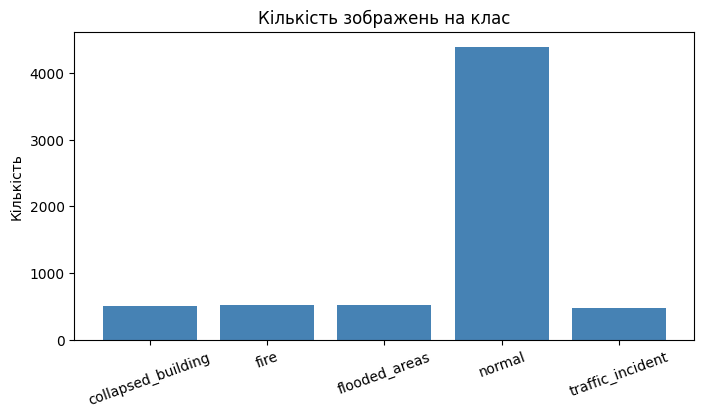

Class collapsed_building: 511 images
Class fire: 521 images
Class flooded_areas: 526 images
Class normal: 4390 images
Class traffic_incident: 485 images


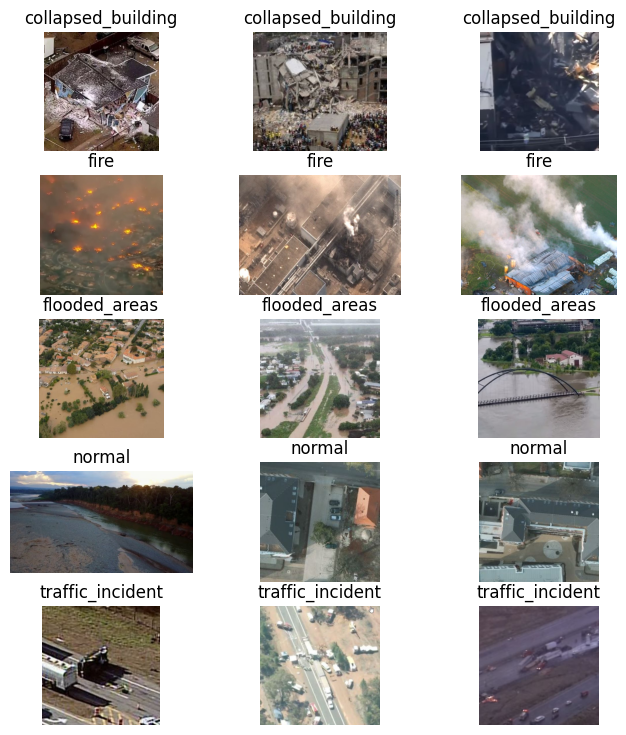

In [5]:
# Список каталогів класів
class_names = ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']

data_stats = {}

for cls in class_names:
    files = list((data_dir/cls).glob("*.jpg"))
    data_stats[cls] = len(files)

data_stats, sum(data_stats.values())

# Візуалізуємо дисбаланс
plt.figure(figsize=(8,4))
plt.bar(list(data_stats.keys()), list(data_stats.values()), color="steelblue")
plt.title("Кількість зображень на клас")
plt.ylabel("Кількість")
plt.xticks(rotation=20)
plt.show()

# Підрахунок кількості зображень за кожним з класів
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f'Class {class_name}: {num_images} images')

# Візуалізація зразків зображень
def plot_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(8, 9))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        sample_images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

plot_sample_images(data_dir, class_names)

### **Підготовка даних: Спосіб 1**

**Цей спосіб доречний**, коли потрібен простий, “все-в-одному” генератор із мінімальним кодом, та коли використовуються  моделі (скрипти), що спираються на `flow_from_directory`.

***Аугментація*** — це процес створення нових тренувальних прикладів шляхом невеликих змін існуючих зображень. Це робить модель розумнішою і стійкішою до змін.

Тепер, коли є "рецепт" аугментації `train_datagen`, потрібна "фабрика", яка буде брати реальні файли з диска, застосовувати до них цей рецепт і подавати їх моделі порціями. Саме це і робить `flow_from_directory`.

**Важливо**: для валідаційних даних застосовуються тільки зміна розміру та нормалізація (rescale). Інші аугментації (повороти, зсуви) не застосовуються, бо ми хочемо оцінити якість моделі на оригінальних, незмінених даних. `ImageDataGenerator` робить це автоматично для валідаційного набору.

In [6]:
IMG_SIZE = (224, 224)  # До такого розміру кожне зображення буде змінено під час завантаження
BATCH_SIZE = 32        # Кількість зображень, що подається моделі за один крок навчання (один “батч”).
EPOCHS = 5             # Кількість епох (циклів навчання). Одна епоха — це коли нейронна мережа подивилася на всі тренувальні зображення один раз.
                       # Щоб добре навчитися, їй потрібно переглянути весь набір даних кілька разів.
SEED = 42              # Фіксує випадковість для відтворюваних результатів (однакове перемішування при кожному запуску).

# Налаштування аугментації для тренувальних даних
train_datagen = ImageDataGenerator(
    #rescale=1./255,        # Не вводиться, оскільки EfficientNetB0 самостійно масштабує пікселі з діапазону 0–255 до 0–1. 
    rotation_range=20,      # випадкове обертання зображення на кут до ±20°
    zoom_range=0.2,         # випадкове збільшення або зменшення масштабу зображення до ±20%
    width_shift_range=0.2,  # випадкове горизонтальне зміщення до ±20% ширини
    height_shift_range=0.2, # випадкове вертикальне зміщення до ±20% висоти
    horizontal_flip=True,
    validation_split=0.2  # 20% даних для валідації (за замовчуванням 0.0)
)

# Створюємо окремий генератор для валідації, щоб уникнути аугментації
validation_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Завантаження даних з папки, автоматично розподіляючи їх по класах (підпапках)
# Створюються два генератори з одного джерела (data_dir), але з різними підмножинами
train_generator = train_datagen.flow_from_directory( 
    data_dir,                 # Шлях до папки з тренувальними зображеннями. Кожна підпапка — це окремий клас.
                              # Зображення з цих підпапок автоматично отримують правильні мітки класів
    target_size=IMG_SIZE,     # Змінити розмір кожного зображення (до 224×224)
    batch_size=BATCH_SIZE,    # Подавати порцію зображень за крок (32 од.).
    class_mode='categorical', # 'categorical' підходить, коли більше ніж 2 класи. Для 2 класів можна використати 'binary'
    subset='training',        # Взяти 80% даних для тренування, бо validation_split=0.2 (за замовчуванням subset=None)
    color_mode='rgb',         # Гарантує, що всі зображення завантажуватимуться з трьома каналами.
    seed=SEED
)

val_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',      # Взяти 20% даних для перевірки (за замовчуванням subset=None)
    color_mode='rgb',
    seed=SEED
)

Found 5147 images belonging to 5 classes.
Found 1286 images belonging to 5 classes.


In [7]:
# Отримаємо словник класів для подальшого використання
class_indices = train_generator.class_indices
# Створимо обернений словник для легкого доступу до назви класу за індексом
labels = {v: k for k, v in class_indices.items()}

print("Знайдені класи та їхні індекси:", class_indices)
print("Обернений словник для прогнозів:", labels)

Знайдені класи та їхні індекси: {'collapsed_building': 0, 'fire': 1, 'flooded_areas': 2, 'normal': 3, 'traffic_incident': 4}
Обернений словник для прогнозів: {0: 'collapsed_building', 1: 'fire', 2: 'flooded_areas', 3: 'normal', 4: 'traffic_incident'}


### **Модель EfficientNetB0**

Це — приклад **Transfer Learning**, однієї з найпотужніших технік у сучасному машинному навчанні.

**Архітектура EfficientNet** представлена набором готових до використання моделей. Вибір залежить від необхідної точності, доступних ресурсів для навчання та дозволу вхідних зображень. Моделі маркуються від B0 (сама проста) до B7 (сама «сильна»).

Назва моделі | Вхідна роздільна здатність
:---- | :----:
EfficientNetB0 | 224х224
EfficientNetB1 | 240х240
EfficientNetB2 | 260х260
EfficientNetB3 | 300х300
EfficientNetB4 | 380х380
EfficientNetB5 | 456х456
EfficientNetB6 | 528х528
EfficientNetB7 | 600х600

З таблиці видно, що моделі EfficientNet приймають на вхід зображення з дозволом, який кратно 8.

Представлені моделі дозволяють використовувати готові веса, які беруться з попередньо отриманих моделей, заснованих на базі даних ImageNet. Це дозволяє значно прискорити навчання підсумкової моделі, так як навчання з нуля вимагає значно більше ресурсів.

```
# Використання попередньо навченої EfficientNetB0
# Версія для Google Colab and Windows (not MacOS)

# Функція створення моделі
def create_model(num_classes):
    base_model = EfficientNetB0(
        weights='imagenet',       # Готові ваги на основі ImageNet
        include_top=False,        # Вказує, чи слід брати готовий або вихідний шар користувача. За замовчуванням True.
                                  # False видаляє "голову" моделі (останній шар, який розпізнавав 1000 класів ImageNet),
                                  # щоб замінити її своєю "головою" для 5 класів.
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    
    # Заморожуємо базову модель, щоб нові шари швидко навчилися на наших даних, не “ламаючи” корисні ознаки з ImageNet
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))  # Вхідний шар, куди подаються зображення
    x = base_model(inputs, training=False)  # Пропускає зображення через EfficientNet.
                         # training=False гарантує, що спеціальні шари (як BatchNormalization) працюють у режимі передбачення, а не навчання.
    x = GlobalAveragePooling2D()(x)  # Перетворює складні "карти ознак" у простий набір чисел
    x = Dropout(0.3)(x)     # Випадково "вимикає" 30% нейронів під час навчання
    outputs = Dense(num_classes, activation='softmax')(x) # Фінальний шар з 5 нейронами (по одному на клас).
                                                          # softmax перетворює числа в ймовірності, що в сумі дають 1.0
    model = Model(inputs, outputs)
    
    # Компіляція моделі
    model.compile(
        optimizer=Adam(learning_rate=1e-3),  # Алгоритм навчання і швидкість навчання
        loss='categorical_crossentropy',     # Спосіб вимірювання помилок для задач з багатьма класами
        metrics=['accuracy']                 # Показувати точність (% правильних відповідей)
    )
    
    return model
    ```

In [8]:
# Використання попередньо навченої EfficientNetB0
# Версія для MacOS

def build_base_efficientnet_b0():
    # Пробуємо звичайним шляхом ('imagenet')
    try:
        base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
        print("✓ Завантажено ваги ImageNet автоматично.")
        return base
    except Exception as e:
        print("⚠️ Автоматичне завантаження ваг не вдалося:", e)
        # Ручне завантаження файлу ваг у кеш Keras
        url = "https://storage.googleapis.com/tensorflow/keras-applications/efficientnet/efficientnetb0_notop.h5"
        weights_path = tf.keras.utils.get_file(
            fname="efficientnetb0_notop.h5",
            origin=url,
            cache_subdir="models"  # ~/.keras/models
            # file_hash можна не вказувати; якщо хочете валідацію — додайте хеш з офіційних джерел
        )
        print("✓ Завантажено вручну до:", weights_path)
        # Передаємо шлях файлу у параметр weights (це підтримується)
        base = EfficientNetB0(include_top=False, weights=weights_path, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
        return base

def create_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name='input_rgb')
    base = build_base_efficientnet_b0()
    base.trainable = False
    x = base(inputs, training=False)                  # EfficientNetB0 всередині робить Rescaling(1/255)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name="efnB0_aider")

    model.compile(optimizer=optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',     # якщо з генератора йдуть one-hot
                  metrics=['accuracy'])
    return model

In [9]:
# Створення моделі
model = create_model(num_classes = len(labels))
model.summary()

2025-08-13 00:36:54.510221: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-08-13 00:36:54.510276: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-08-13 00:36:54.510283: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1755034614.510524 14829053 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755034614.510723 14829053 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


⚠️ Автоматичне завантаження ваг не вдалося: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
✓ Завантажено вручну до: /Users/admin/.keras/models/efficientnetb0_notop.h5


Model: "efnB0_aider"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_rgb (InputLayer)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### **Навчання моделі EfficientNetB0**

In [10]:
# Навчання моделі EfficientNetB0 без змін

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Навчання
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

/opt/anaconda3/envs/nubip/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-08-13 00:36:58.595083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 216ms/step - accuracy: 0.7851 - loss: 0.6380 - val_accuracy: 0.8678 - val_loss: 0.3837
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.8737 - loss: 0.3720 - val_accuracy: 0.8810 - val_loss: 0.3268
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.8999 - loss: 0.3002 - val_accuracy: 0.8896 - val_loss: 0.3138
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - accuracy: 0.9036 - loss: 0.2856 - val_accuracy: 0.8919 - val_loss: 0.3012
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - accuracy: 0.9065 - loss: 0.2686 - val_accuracy: 0.9012 - val_loss: 0.2766


### **Оцінка і візуалізація результатів моделі EfficientNetB0**

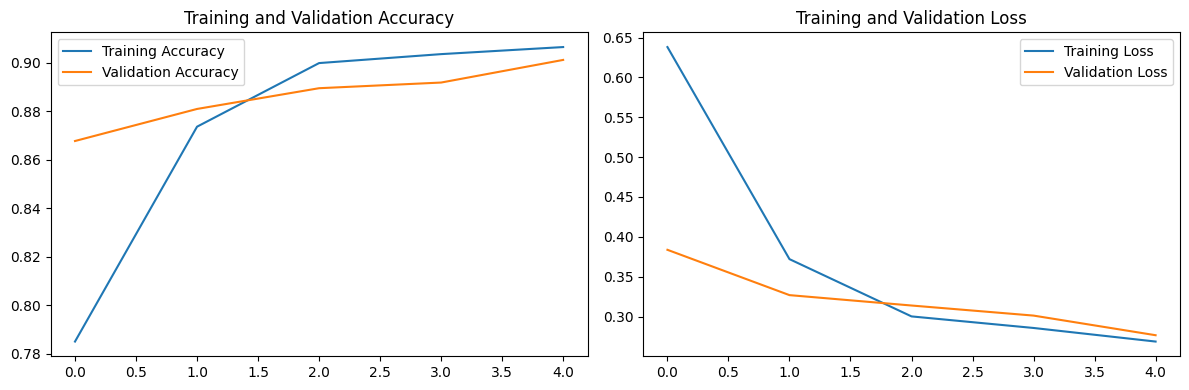

In [11]:
# Графіки точності (accuracy) та втрат (loss) на тренуванні та валідації
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def predict_image(image_path, model, img_size, class_labels):
    """
    Функція для завантаження, підготовки зображення, 
    прогнозування класу та візуалізації результату.
    """
    # 1. Завантаження та підготовка зображення
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0) # Створення "батчу" з одного зображення

    # 2. Прогнозування
    predictions = model.predict(img_batch)
    probabilities = predictions[0] * 100  # Переводимо у відсотки
    
    # 3. Аналіз результату
    # predictions - це масив ймовірностей, наприклад [[0.05, 0.01, 0.9, 0.02, 0.02]]
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_labels[predicted_index]
    confidence = np.max(predictions[0]) * 100
    
    # 4. Візуалізація
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Прогноз: {predicted_label}\nВпевненість: {confidence:.2f}%", fontsize=14)
    plt.axis("off")
    plt.show()
    
    # 5. Детальний вивід ймовірностей для кожного класу
    print("--- Детальний аналіз прогнозу ---")
    print(f"Шлях до файлу: {image_path}\n")
    
    for i in range(len(class_labels)):
      label = class_labels[i]
      probability = predictions[0][i] * 100
      print(f"Клас: {label:<20} | Ймовірність: {probability:.4f}%")
    
    # 6. Візуалізація графіка ймовірностей
    fig, ax = plt.subplots(figsize=(6, 5))
    class_names = list(class_labels.values())
    y_pos = np.arange(len(class_names))
    
    bars = ax.barh(y_pos, probabilities, align='center', color='skyblue')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names)
    ax.invert_yaxis()  # Мітка з найвищою ймовірністю буде зверху
    ax.set_xlabel('Ймовірність, %')
    ax.set_title('Розподіл ймовірностей за класами')
    ax.set_xlim(0, 100)

    # Додаємо значення відсотків на сам графік
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')
        
    plt.show()


Тестуємо модель на зображенні з класу 'fire'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


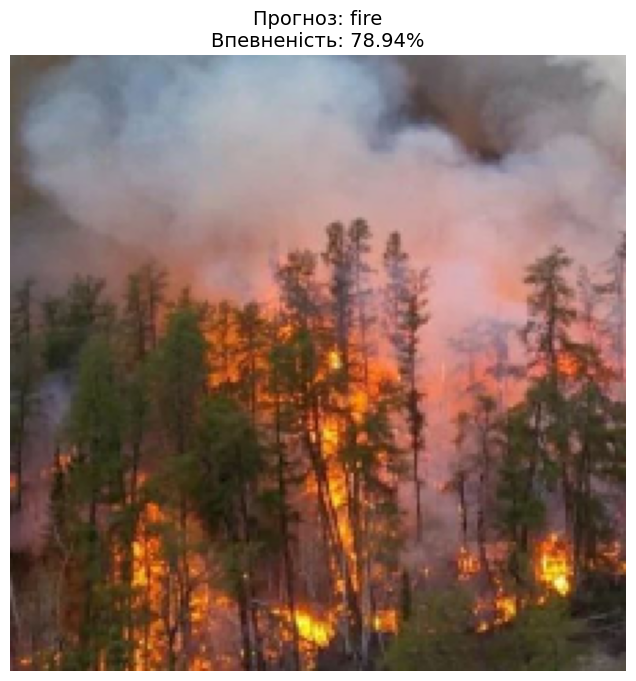

--- Детальний аналіз прогнозу ---
Шлях до файлу: Data/AIDER/fire/fire_image0478.jpg

Клас: collapsed_building   | Ймовірність: 0.0230%
Клас: fire                 | Ймовірність: 78.9395%
Клас: flooded_areas        | Ймовірність: 0.1427%
Клас: normal               | Ймовірність: 20.8127%
Клас: traffic_incident     | Ймовірність: 0.0821%


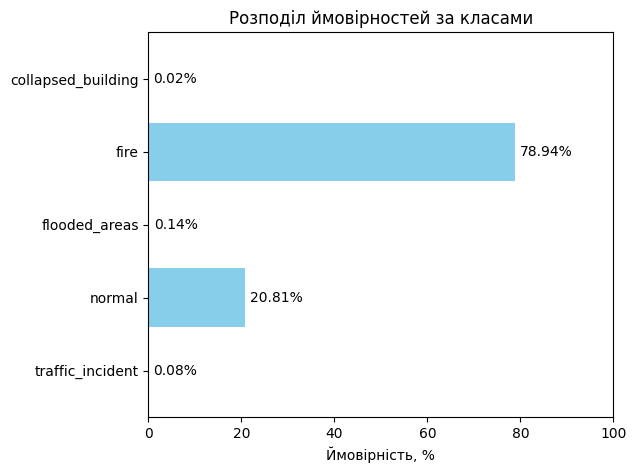

In [13]:
# --- Виконання прогнозу ---

# Виберемо випадкове зображення з одного з класів для тесту
random.seed(2456)
try:
    # Спробуємо взяти фото з пожежею
    test_class = 'fire'    # 'fire'  'collapsed_building'
    test_class_path = os.path.join(data_dir, test_class)
    random_image_name = random.choice(os.listdir(test_class_path))
    image_to_predict = os.path.join(test_class_path, random_image_name)

    print(f"\nТестуємо модель на зображенні з класу '{test_class}'...")
    predict_image(image_to_predict, model, IMG_SIZE, labels)

except FileNotFoundError:
    print(f"\nПОМИЛКА: Не вдалося знайти тестове зображення. Перевірте шлях: {test_class_path}")
except Exception as e:
    print(f"\nВиникла помилка при прогнозуванні: {e}")

**Confustion matrix (матриця плутанини)**

Found 1286 images belonging to 5 classes.


/opt/anaconda3/envs/nubip/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step
Створено карту класів: {0: 'collapsed_building', 1: 'fire', 2: 'flooded_areas', 3: 'normal', 4: 'traffic_incident'}


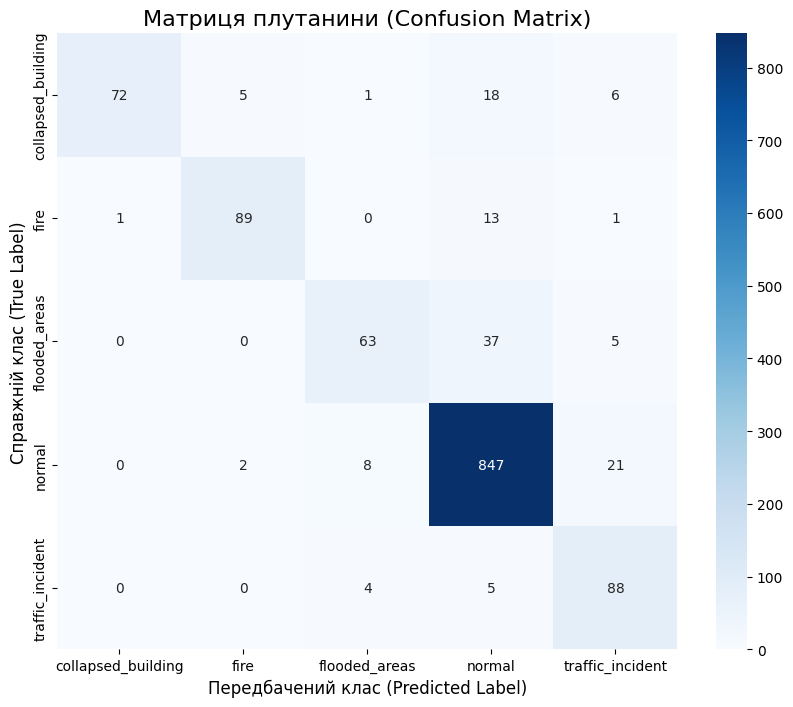

In [14]:
## Крок 1: Отримання прогнозів та справжніх міток

# ВАЖЛИВО: Для коректної побудови матриці плутанини,
# генератор валідації НЕ ПОВИНЕН перемішувати дані.
# Переконайтеся, що у вашому val_gener є параметр shuffle=False.
# Якщо його немає, оновіть створення val_gener так:

val_gener = validation_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, # Можна встановити 1 для точності, але не обов'язково
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    seed=SEED,
    shuffle=False  # <--- Цей рядок критично важливий!
)

# Отримуємо прогнози моделі для всього валідаційного набору
y_pred_probs = model.predict(val_gener)

# Перетворюємо ймовірності в конкретні класи (індекс з максимальною ймовірністю)
y_pred = np.argmax(y_pred_probs, axis=1)

# Отримуємо справжні мітки класів з генератора
y_true = val_gener.classes


class_indices = train_generator.class_indices
label_map = {v: k for k, v in class_indices.items()} # Назвали 'label_map'
print("Створено карту класів:", label_map)
# Отримуємо назви класів для підписів на графіку
class_names = list(label_map.values())

## Крок 2: Побудова та візуалізація матриці плутанини

# Розраховуємо матрицю
cm = confusion_matrix(y_true, y_pred)

# Створюємо графік за допомогою seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

# Додаємо підписи та заголовок
plt.title('Матриця плутанини (Confusion Matrix)', fontsize=16)
plt.ylabel('Справжній клас (True Label)', fontsize=12)
plt.xlabel('Передбачений клас (Predicted Label)', fontsize=12)
plt.show()

**Classification report**

In [15]:
# Створюємо звіт, передаючи справжні та передбачені мітки, а також назви класів
report = classification_report(y_true, y_pred, target_names=class_names)

# Виводимо звіт у консоль
print(report)

                    precision    recall  f1-score   support

collapsed_building       0.99      0.71      0.82       102
              fire       0.93      0.86      0.89       104
     flooded_areas       0.83      0.60      0.70       105
            normal       0.92      0.96      0.94       878
  traffic_incident       0.73      0.91      0.81        97

          accuracy                           0.90      1286
         macro avg       0.88      0.81      0.83      1286
      weighted avg       0.90      0.90      0.90      1286



**Precision** (Точність): Відповідає на питання: "З усіх об'єктів, які модель назвала цим класом, скільки насправді є цим класом?". Висока точність означає мало хибних спрацьовувань.
(Аналогія: Якщо модель сказала "це пожежа", наскільки ми можемо їй вірити?)

**Recall** (Повнота): Відповідає на питання: "З усіх об'єктів, які реально належать до цього класу, скільки модель змогла знайти?". Висока повнота означає, що модель знаходить майже всі об'єкти потрібного класу.
(Аналогія: Якщо в даних було 100 пожеж, скільки з них модель знайшла?)

**F1-score**: Це середнє гармонійне між точністю та повнотою. Це єдина метрика, яка дозволяє оцінити баланс між цими двома показниками. Чим ближче до 1.0, тим краще.

**Support**: Це просто кількість реальних екземплярів кожного класу у вашому валідаційному наборі даних.

**Accuracy**: Загальна частка правильних прогнозів по всіх класах.

**Macro Avg**: Середнє арифметичне метрик по всіх класах (кожен клас має однакову вагу).

**Weighted Avg**: Середнє зважене метрик, де вага кожного класу залежить від його розміру (support). Цей показник є більш інформативним для незбалансованих наборів даних, як-от ваш, де клас normal значно більший за інші.

---
---

### **Підготовка даних: Спосіб 2**

**Цей спосіб доречний**, коли важлива продуктивність, відтворюваність, інтеграція з tf.data та виконання препроцесингу / аугментацій на пристрої. А також підходить для масштабних пайплайнів і продакшн-сценаріїв

In [16]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Зчитати набір зображень за допомогою TensorFlow
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Нормалізувати значення пікселів в діапазоні [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)  
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Здійснити аугментацію
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),  # Обертання на [-0.2, 0.2] радіанів, або, точніше, [-0.2 * 2π, 0.2 * 2π] радіанів,
                                          # що еквівалентно [-72, 72] градусів)
    tf.keras.layers.RandomZoom(0.2),      # масштаб у діапазоні [0.8, 1.2]
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2) # Зсув по ширині/висоті:
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Оптимізація продуктивності набору даних
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6433 files belonging to 5 classes.
Using 5147 files for training.
Found 6433 files belonging to 5 classes.
Using 1286 files for validation.


### **Порівняння способів 1 і 2**

**Обидва способи підготовки даних** виконують одне й те саме базове завдання: завантажують зображення з папок, ділять їх на тренувальний та валідаційний набори, змінюють розмір, нормалізують та аугментують.

Проте вони представляють два різних покоління API в TensorFlow/Keras, і між ними є суттєві відмінності в підході, гнучкості та, що найважливіше, продуктивності.

**Ключові відмінності між Способамм 1 і 2 (ImageDataGenerator і	tf.data.Dataset)**

* **Основний інструмент** 
  * _Спосіб 1_: Класичний Keras API. Використовує клас ImageDataGenerator та його метод flow_from_directory. 
  * _Спосіб 2_: Сучасний TensorFlow API. Використовує tf.keras.utils.image_dataset_from_directory та об'єкти tf.data.Dataset.
* **Продуктивність**
  * _Спосіб 1_: Повільніший. Дані генеруються "на льоту" в одному потоці Python, що може створювати "пляшкове горло" (GPU простоює, чекаючи на дані від CPU).
  * _Спосіб 2_: Значно швидший. Використовує tf.data API, який оптимізований для високої продуктивності. Методи .cache() та .prefetch() дозволяють: 
    - .cache(): зберігати дані в пам'яті після першого завантаження. 
    - .prefetch(): готувати наступну порцію даних на CPU, поки GPU обробляє поточну.
* **Гнучкість** 
  * _Спосіб 1_: Обмежена. Ви можете використовувати лише ті аугментації, які вбудовані в ImageDataGenerator. Створити складний конвеєр обробки важко.
  * _Спосіб 2_: Дуже висока. Ви можете створювати будь-які конвеєри обробки за допомогою методу .map(), комбінуючи шари Keras та власні функції TensorFlow.
* **Застосування аугментації** 
  * _Спосіб 1_: Аугментація є частиною самого генератора. Всі налаштування задаються при його створенні.	
  * _Спосіб 2_: Аугментація та нормалізація — це окремі кроки, які застосовуються до набору даних через .map(). Це робить код більш модульним і читабельним.
* **Де виконуються аугментації**
  * _Спосіб 1_: У CPU на льоту через ImageDataGenerator (поза графом).
  * _Спосіб 2_: Через Keras preprocessing layers у графі, можуть виконуватися на GPU/TPU
* **Інтеграція з моделлю**	
  * _Спосіб 1_: Обробка даних відбувається поза моделлю. 
  * _Спосіб 2_: Шари аугментації (data_augmentation) та нормалізації (normalization_layer) можна включити безпосередньо в саму модель як перші шари. Це робить модель самодостатньою (легше зберігати та розгортати).
* **Читабельність коду** 
  * _Спосіб 1_: Більш компактний для простих завдань.	
  * _Спосіб 2_: Більш багатослівний, але чітко розділяє кроки: завантаження, нормалізація, аугментація, оптимізація.

**Висновок**:
* _**Спосіб 1 (ImageDataGenerator)**_ — це старий, але все ще робочий підхід. Він простий і швидкий для написання, ідеально підходить для швидких експериментів або навчальних проєктів.
* _**Спосіб 2 (tf.data.Dataset)**_ — це сучасний стандарт і найкраща практика. Він забезпечує значно вищу продуктивність, що критично для великих наборів даних та складних моделей. Він більш гнучкий і дозволяє створювати складні та оптимізовані конвеєри даних.

### **Модель CNN (TF Keras)**

In [17]:
# Побудувати згорткову нейронну мережу
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Скомпілювати нейромережеву модель з усіма доданими властивостями
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Резюме моделі
model2.summary()

# Тренування моделі
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

/opt/anaconda3/envs/nubip/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-08-13 00:39:54.171834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:56: Filling up shuffle buffer (this may take a while): 64 of 1000
2025-08-13 00:40:04.199797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:56: Filling up shuffle buffer (this may take a while): 130 of 1000
2025-08-13 00:40:08.785161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


161/161 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.5327 - loss: 3.1599 - val_accuracy: 0.7216 - val_loss: 0.9924
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6532 - loss: 1.1081 - val_accuracy: 0.7216 - val_loss: 0.9863
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6616 - loss: 1.0516 - val_accuracy: 0.7395 - val_loss: 0.7514
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6672 - loss: 1.0429 - val_accuracy: 0.7527 - val_loss: 0.7611
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6555 - loss: 1.3181 - val_accuracy: 0.7341 - val_loss: 0.9078
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6903 - loss: 1.0420 - val_accuracy: 0.7457 - val_loss: 0.8759
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6715 - loss: 1.1198 - val_accuracy: 0.7473 - val_loss: 0.7937
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6820 - loss: 1.1555 - val_accuracy: 0.63

### **Оцінка і візуалізація результатів моделі CNN**

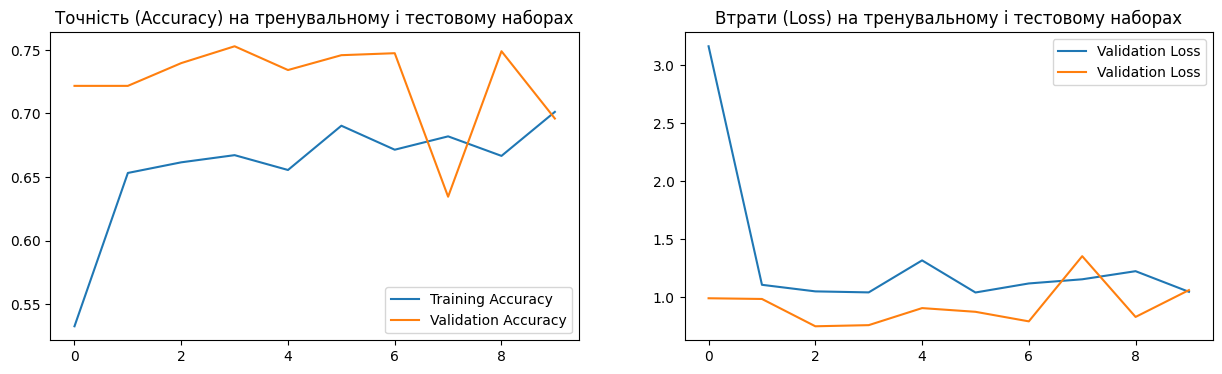

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6960 - loss: 1.0626
Validation Loss: 1.0626
Validation Accuracy: 0.6960


In [18]:
# Вивести результати тренування графічно
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Точність (Accuracy) на тренувальному і тестовому наборах')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Validation Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Втрати (Loss) на тренувальному і тестовому наборах')
    plt.legend()

    plt.show()

plot_training_history(history)

# Оцінити модель
val_loss, val_accuracy = model2.evaluate(val_ds)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


Тестуємо модель на зображенні з класу 'fire'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


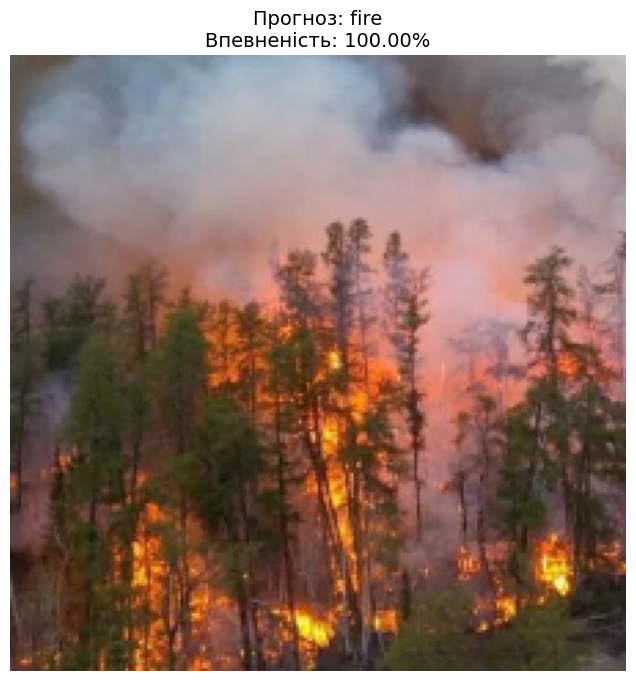

--- Детальний аналіз прогнозу ---
Шлях до файлу: Data/AIDER/fire/fire_image0478.jpg

Клас: collapsed_building   | Ймовірність: 0.0000%
Клас: fire                 | Ймовірність: 100.0000%
Клас: flooded_areas        | Ймовірність: 0.0000%
Клас: normal               | Ймовірність: 0.0000%
Клас: traffic_incident     | Ймовірність: 0.0000%


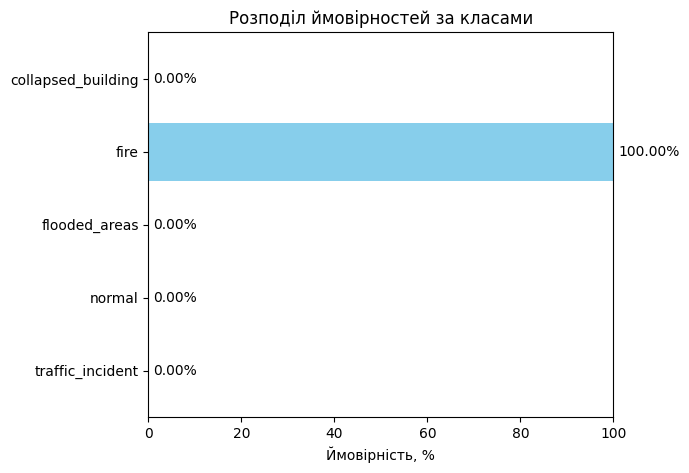

In [19]:
# Прогноз екземпляра
# Виберемо випадкове зображення з одного з класів для тесту
random.seed(2456)
try:
    # Спробуємо взяти фото з надзвичайною ситуацією
    test_class = 'fire'    # 'fire'  'collapsed_building'
    test_class_path = os.path.join(data_dir, test_class)
    random_image_name = random.choice(os.listdir(test_class_path))
    image_to_predict = os.path.join(test_class_path, random_image_name)

    print(f"\nТестуємо модель на зображенні з класу '{test_class}'...")
    predict_image(image_to_predict, model2, IMG_SIZE, labels)

except FileNotFoundError:
    print(f"\nПОМИЛКА: Не вдалося знайти тестове зображення. Перевірте шлях: {test_class_path}")
except Exception as e:
    print(f"\nВиникла помилка при прогнозуванні: {e}")

**Confustion matrix (матриця плутанини)**

2025-08-13 00:41:28.149434: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


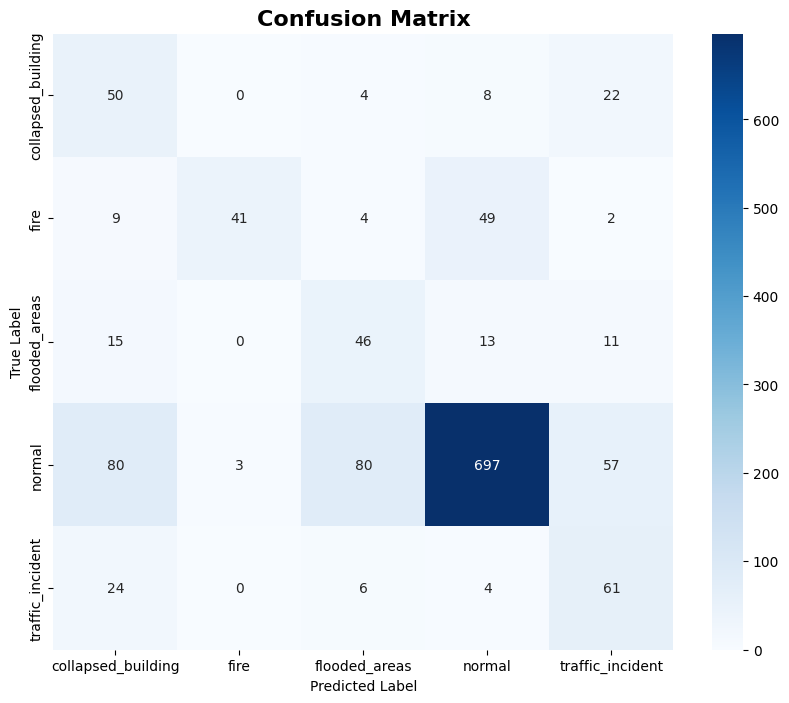

In [20]:
# Збираємо всі передбачення та справжні мітки
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model2.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Створення матриці плутанини
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [21]:
# Створюємо звіт, передаючи справжні та передбачені мітки, а також назви класів
report = classification_report(y_true, y_pred, target_names=class_names)

# Виводимо звіт у консоль
print(report)

                    precision    recall  f1-score   support

collapsed_building       0.28      0.60      0.38        84
              fire       0.93      0.39      0.55       105
     flooded_areas       0.33      0.54      0.41        85
            normal       0.90      0.76      0.83       917
  traffic_incident       0.40      0.64      0.49        95

          accuracy                           0.70      1286
         macro avg       0.57      0.59      0.53      1286
      weighted avg       0.79      0.70      0.72      1286



### **References**

1. Kyrkou, C., & Theocharides, T. (2020). "EmergencyNet: Efficient Aerial Image Classification for Drone-Based Emergency Monitoring Using Atrous Convolutional Feature Fusion." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 13, 1687-1699.
2. Kyrkou, C., & Theocharides, T. (2019). "Deep-Learning-Based Aerial Image Classification for Emergency Response Applications using Unmanned Aerial Vehicles." CVPR Workshops, UAVision 2019.
3. Kyrkou, C. (2020). AIDER (Aerial Image Dataset for Emergency Response Applications) (1.0) [Data set]. Zenodo. DOI: https://doi.org/10.5281/zenodo.3888300. URL: https://zenodo.org/records/3888300